In [7]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

In [8]:
results_dir = "results/masking_experiments_avgfp_Ridge"

In [9]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", 
             #"ProtVec"
             ]
masks = ["relative", "shannon", "lockless", "inverted_relative", "inverted_shannon", "inverted_lockless", "normalized_relative", "normalized_shannon", "normalized_lockless", "random"]
labeled_sizes_list = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.03, 0.01]

In [10]:
global_pred_dict = dict()

for enc in encodings:

    global_pred_dict[enc] = dict()   
    for mask in masks:
        global_pred_dict[f'{enc}_masked_{mask}'] = dict()

    for labeled_size in labeled_sizes_list:
        with open(f'{results_dir}/pred_dict_{enc}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc][labeled_size] = pkl.load(f)
        for mask in masks:
            with open(f'{results_dir}/pred_dict_{enc}_masked_{mask}_{labeled_size}.pickle', 'rb') as f:
                global_pred_dict[f'{enc}_masked_{mask}'][labeled_size] = pkl.load(f)

In [11]:
print(global_pred_dict.keys())
print(global_pred_dict["One_hot"].keys())
print(global_pred_dict["One_hot"][1].keys())
print(global_pred_dict["One_hot"][1][1].keys())

dict_keys(['One_hot', 'One_hot_masked_relative', 'One_hot_masked_shannon', 'One_hot_masked_lockless', 'One_hot_masked_inverted_relative', 'One_hot_masked_inverted_shannon', 'One_hot_masked_inverted_lockless', 'One_hot_masked_normalized_relative', 'One_hot_masked_normalized_shannon', 'One_hot_masked_normalized_lockless', 'One_hot_masked_random', 'One_hot_6_bit', 'One_hot_6_bit_masked_relative', 'One_hot_6_bit_masked_shannon', 'One_hot_6_bit_masked_lockless', 'One_hot_6_bit_masked_inverted_relative', 'One_hot_6_bit_masked_inverted_shannon', 'One_hot_6_bit_masked_inverted_lockless', 'One_hot_6_bit_masked_normalized_relative', 'One_hot_6_bit_masked_normalized_shannon', 'One_hot_6_bit_masked_normalized_lockless', 'One_hot_6_bit_masked_random', 'Binary_5_bit', 'Binary_5_bit_masked_relative', 'Binary_5_bit_masked_shannon', 'Binary_5_bit_masked_lockless', 'Binary_5_bit_masked_inverted_relative', 'Binary_5_bit_masked_inverted_shannon', 'Binary_5_bit_masked_inverted_lockless', 'Binary_5_bit_mask

In [12]:
# Create results dataframe
df = pd.DataFrame(columns=['Labeled', 'Train_size', 'Encoding', 'MSE', 'Spearman_r', 'Weighted_tau'])
for encoding, labeled_sizes in global_pred_dict.items():
    for labeled_size, folds in labeled_sizes.items():
        for fold, results in folds.items():
            y_proba = results["y_proba"]
            y_test = results["original_y_test"]
            train_size = results["train_len"]
            mse = mean_squared_error(y_test, y_proba)
            rmse = np.sqrt(mse)
            spearman_r = spearmanr(y_test, y_proba)[0]
            weighted_tau = weightedtau(y_test, y_proba)[0]
            enc_value = encoding.split("_masked")[0]        
            mask_value = encoding.split("_masked_")[1] if "masked" in encoding else "unmasked"
            df = pd.concat([df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'Encoding': enc_value,
                                              'Mask': mask_value,
                                              'MSE': mse, 
                                              'RMSE': rmse,
                                              'Spearman_r': spearman_r,
                                              'Weighted_tau': weighted_tau
                                              }, index=[0])], ignore_index=True)

In [13]:
# Get values for encoding onehot and labeled 1
df[(df["Encoding"] == "One_hot") & (df["Labeled"] == 1) & ((df["Mask"] == "unmasked") | (df["Mask"] == "normalized_relative"))].groupby(["Mask"]).mean()

,MSE,Spearman_r,Weighted_tau,RMSE
Mask,,,,
normalized_relative,0.344914,0.863656,0.753730,0.587283
unmasked,0.349317,0.860890,0.710327,0.591021


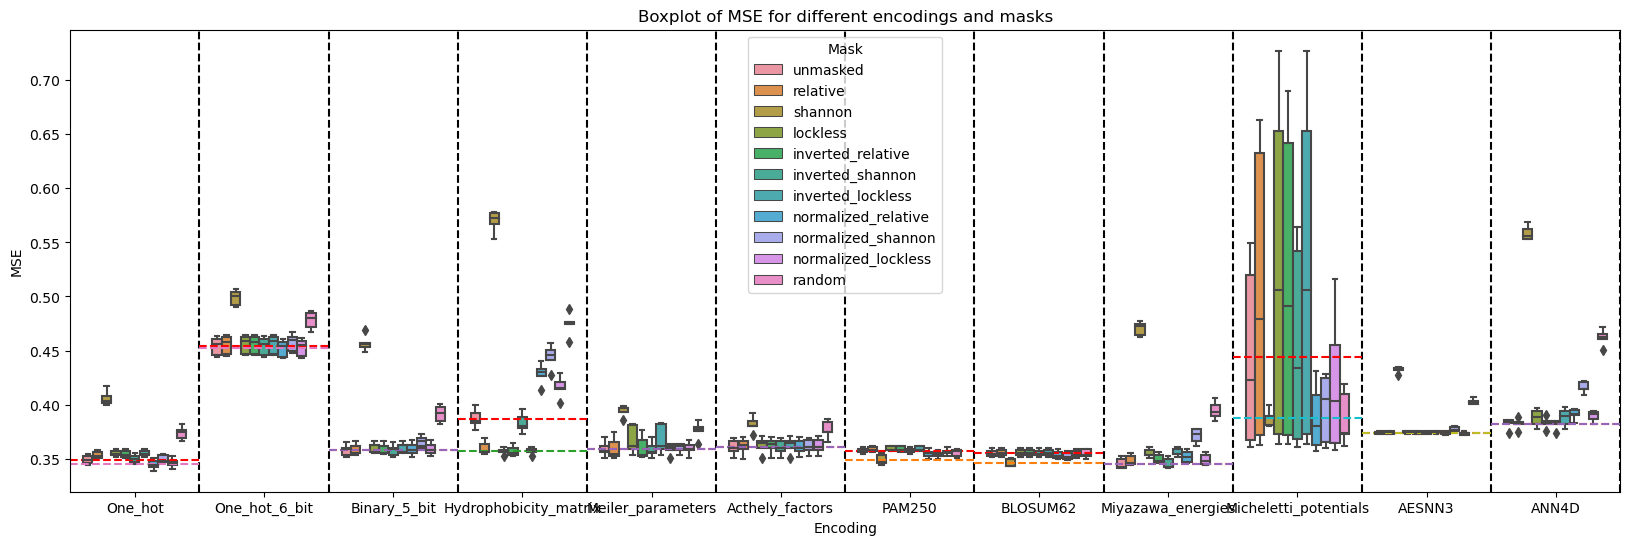

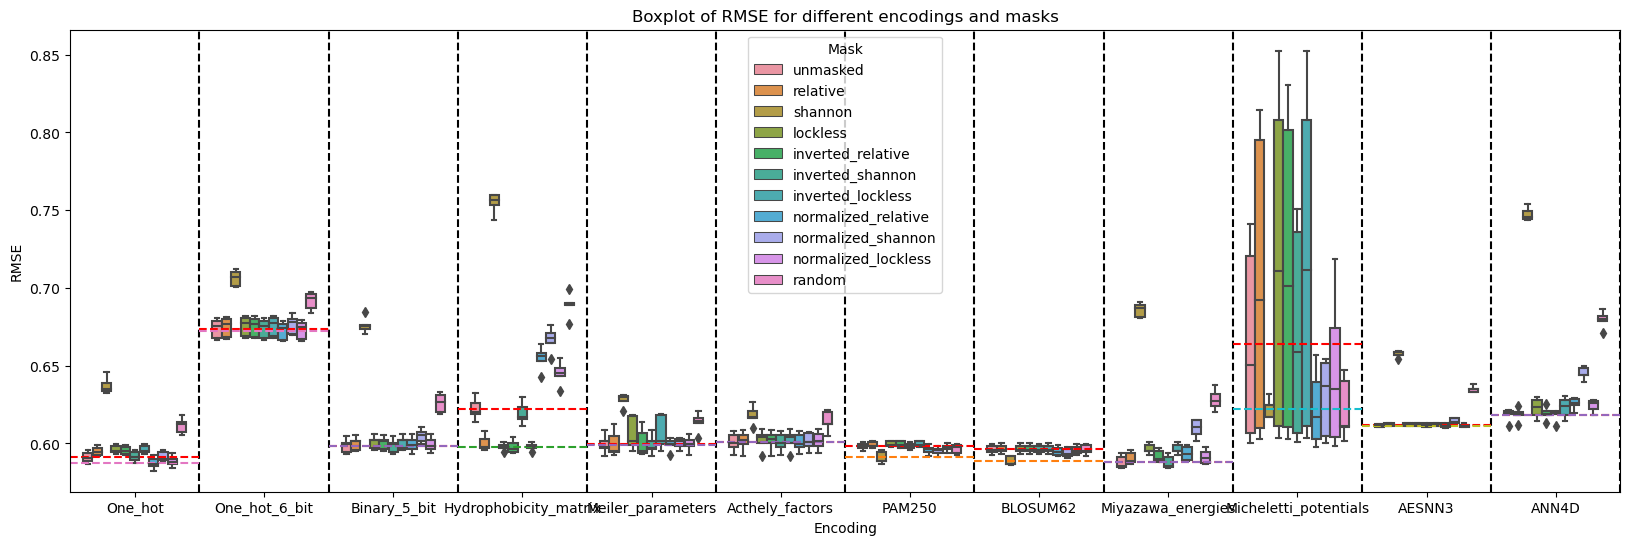

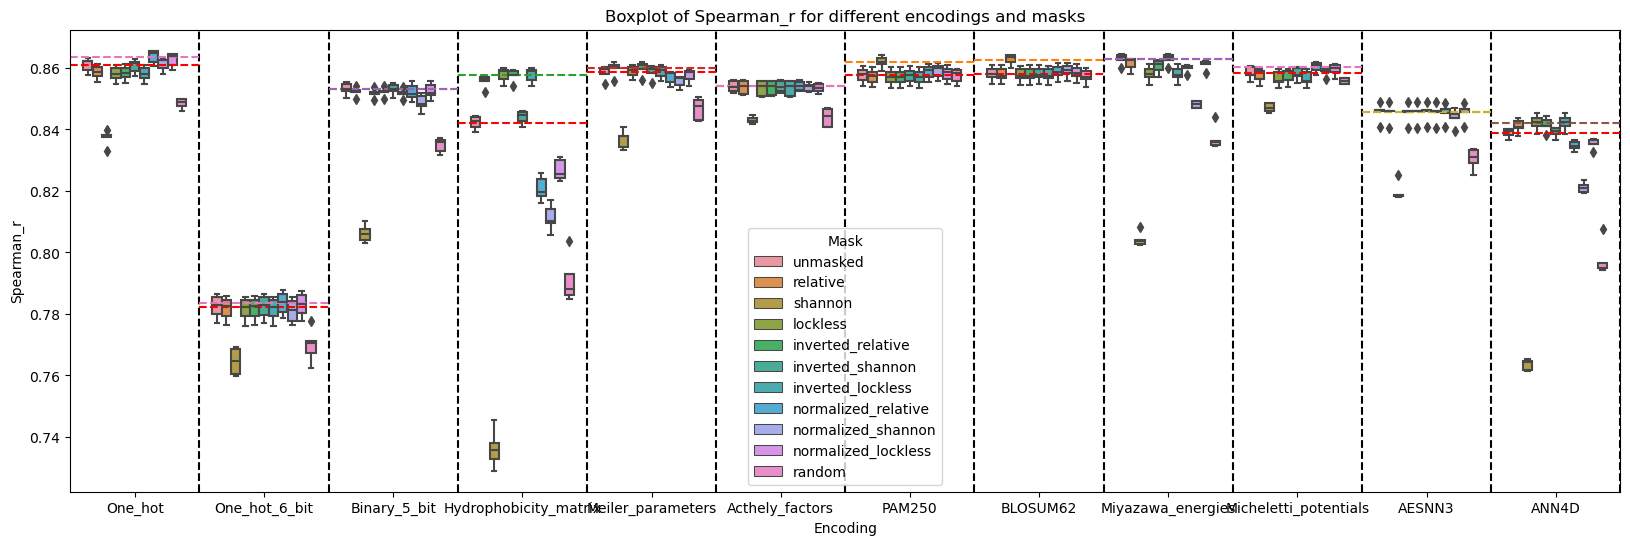

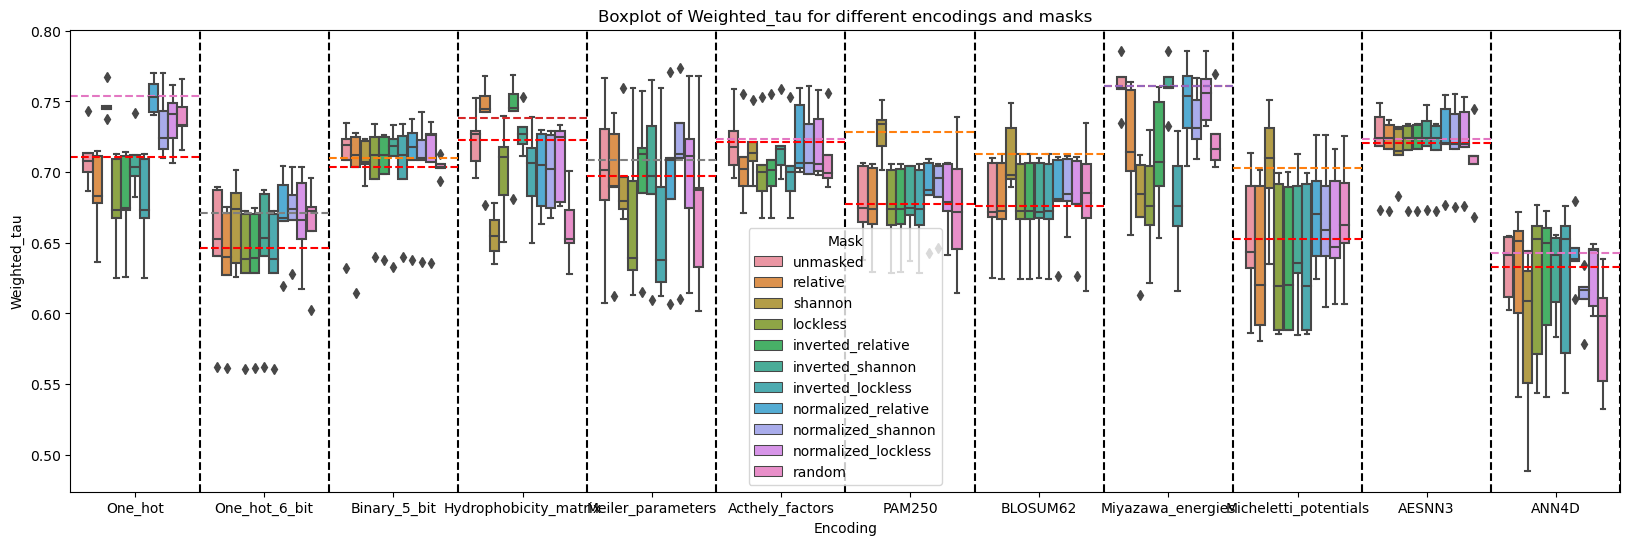

In [15]:
selected_metrics = ["MSE", "RMSE", "Spearman_r", "Weighted_tau"]
for selected_metric in selected_metrics:
    labeled_size = 1
  
    # Boxplot grouped by Encoding
    plt.figure(figsize=(20, 6))
    sns.boxplot(x="Encoding", y=selected_metric, hue="Mask", data=df[df["Labeled"] == labeled_size])
    [plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(encodings))]
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each encoding group
    for enc in encodings:
        # Get the color used in the boxplot for unmaksed
        color = sns.color_palette()[0]
        plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] == "unmasked")][selected_metric].mean(), 
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings), 
                    color = "red", linestyle='--')
        # Draw anothe line with the best value other than unmasked
        if selected_metric == 'MSE' or selected_metric == 'RMSE':
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin(),
            best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings),
                    color = best_mask_color, linestyle='--')
        else:
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
            best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings),
                    color = best_mask_color, linestyle='--')

    plt.title(f"Boxplot of {selected_metric} for different encodings and masks")
    plt.show()


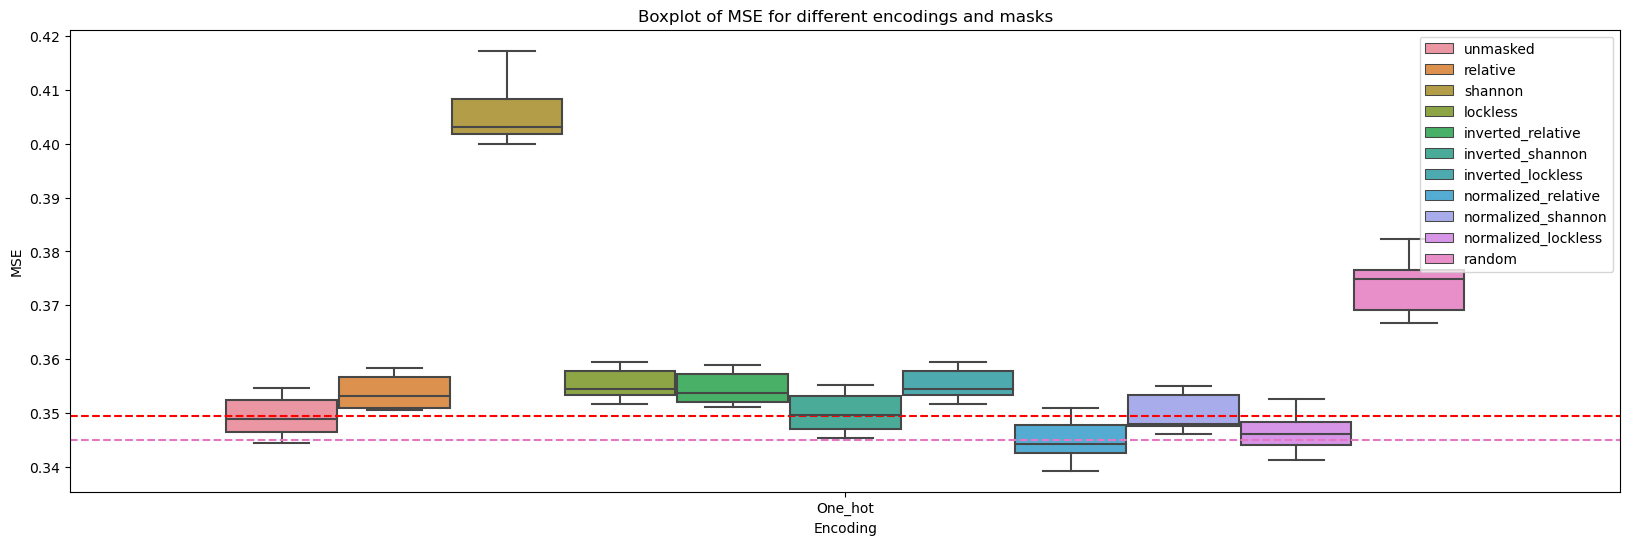

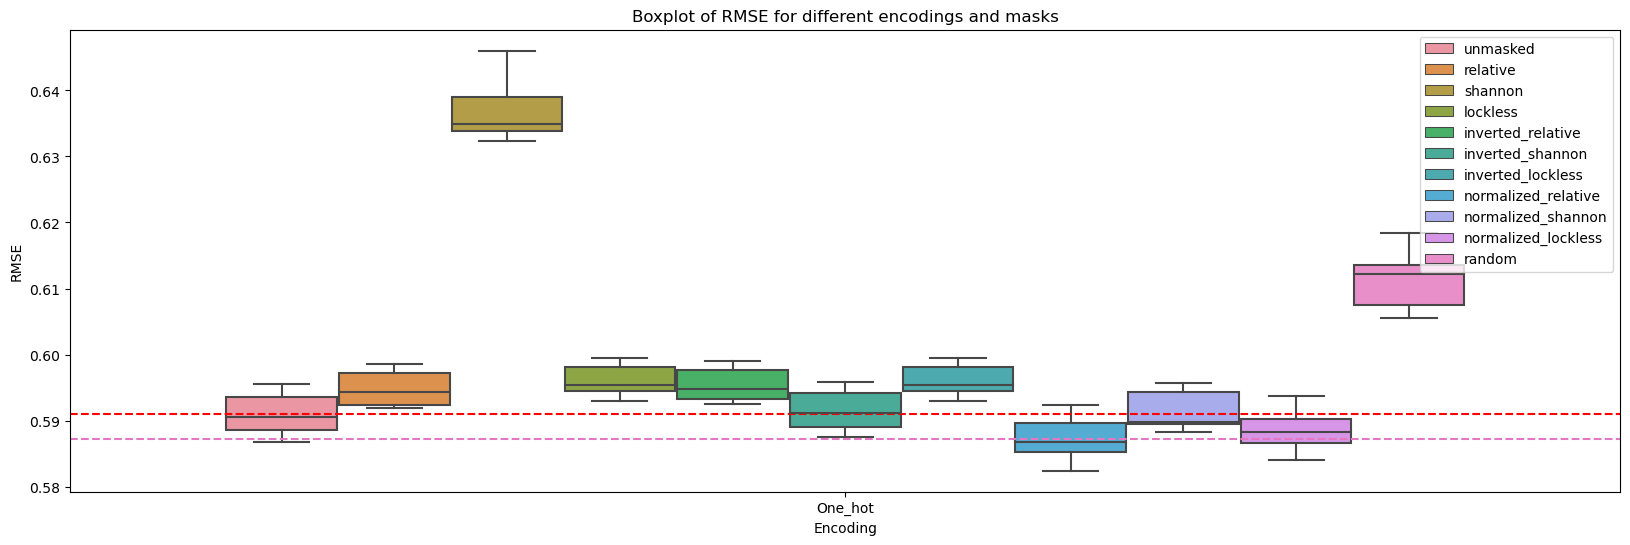

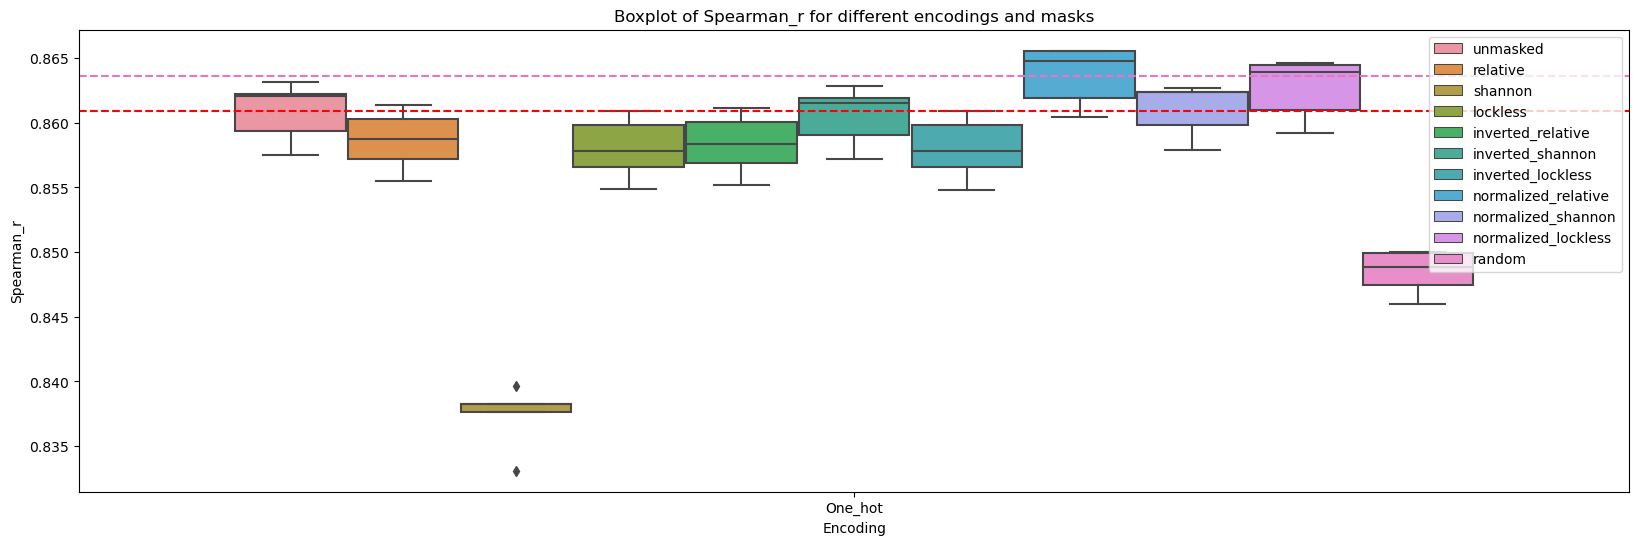

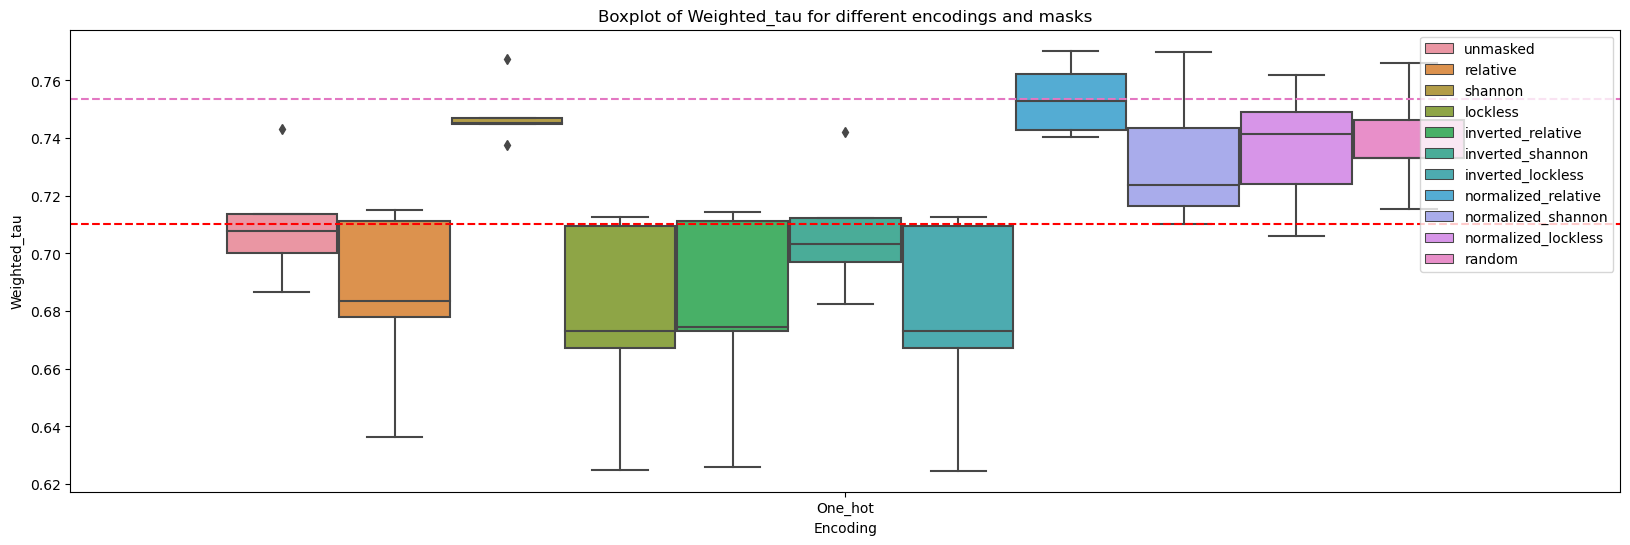

In [16]:
selected_metrics = ["MSE", "RMSE", "Spearman_r", "Weighted_tau"]
for selected_metric in selected_metrics:
    labeled_size = 1

    # Boxplot grouped by Encoding
    plt.figure(figsize=(20, 6))
    sns.boxplot(x="Encoding", y=selected_metric, hue="Mask", data=df[df["Labeled"] == labeled_size & (df["Encoding"] == "One_hot")])
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each encoding group
    plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] == "unmasked")][selected_metric].mean(),
                        color = 'red', linestyle='--')
    # Draw anothe line with the best value other than unmasked
    if selected_metric == 'MSE' or selected_metric == 'RMSE':
        # Get the same color as the boxplot
        best_mask_name = df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin(),
        best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
        plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                    color = best_mask_color, linestyle='--')
    else:
        # Get the same color as the boxplot
        best_mask_name = df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
        best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
        plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                    color = best_mask_color, linestyle='--')

    plt.title(f"Boxplot of {selected_metric} for different encodings and masks")
    plt.legend(loc='upper right')
    plt.show()


/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


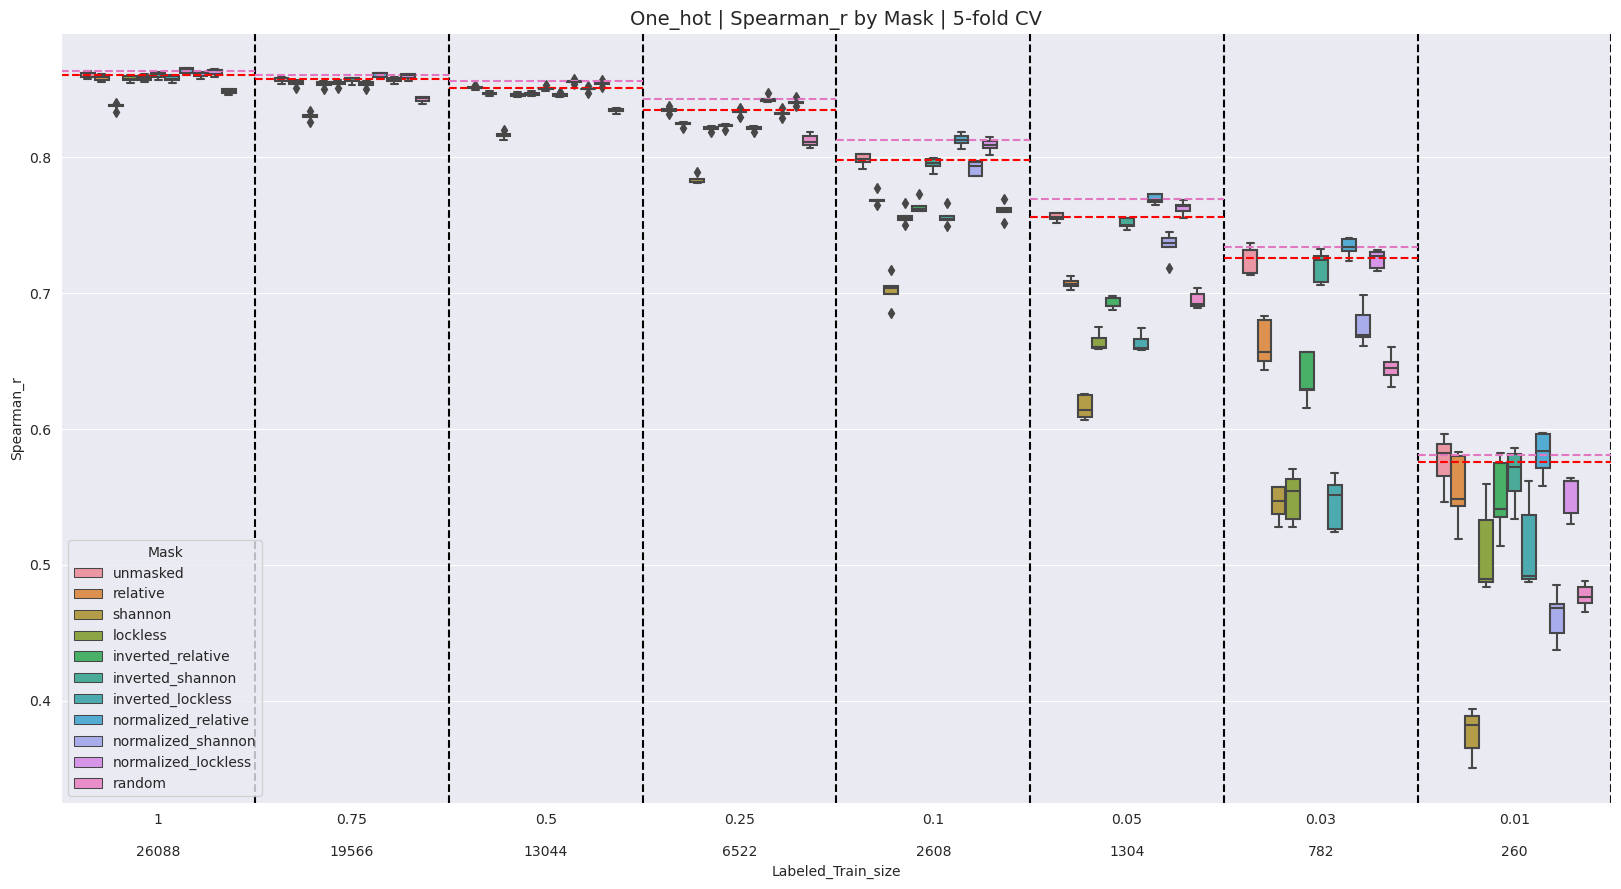

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


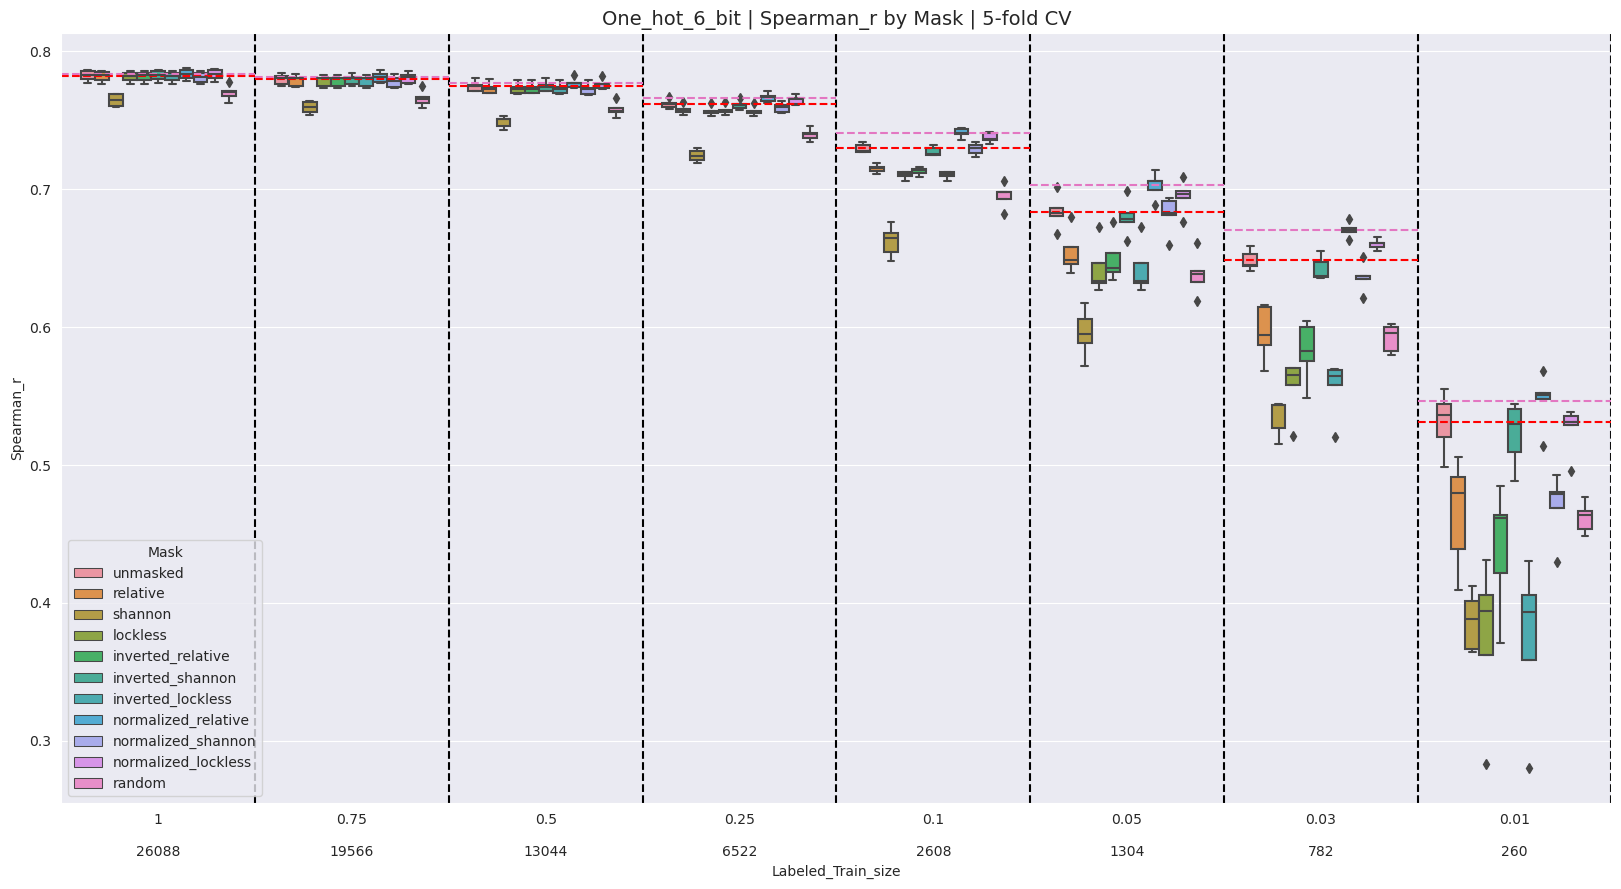

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


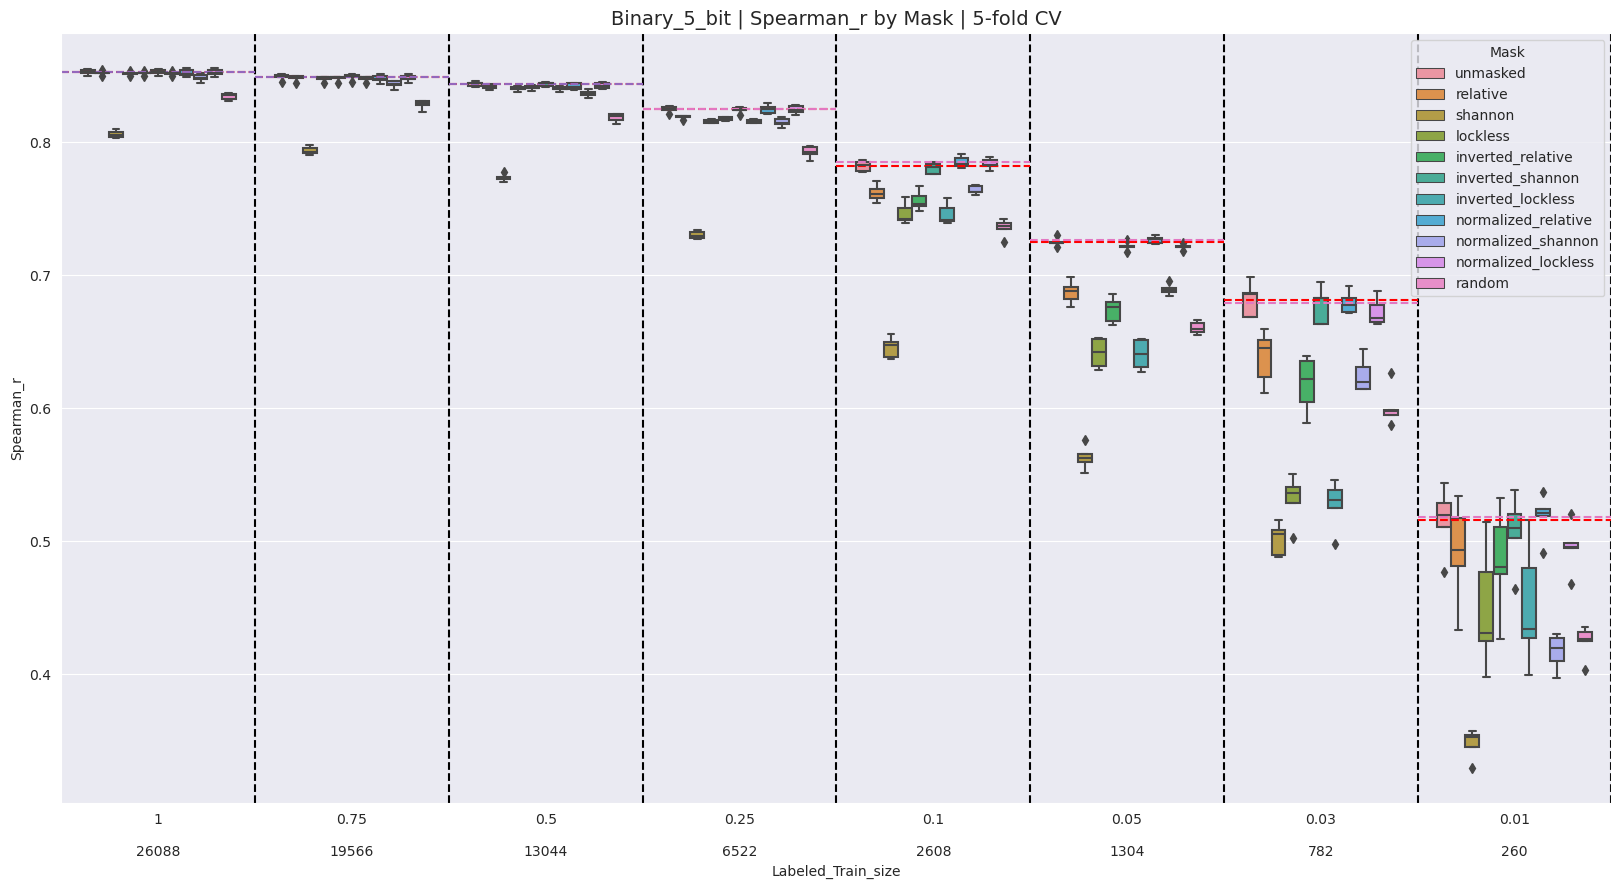

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


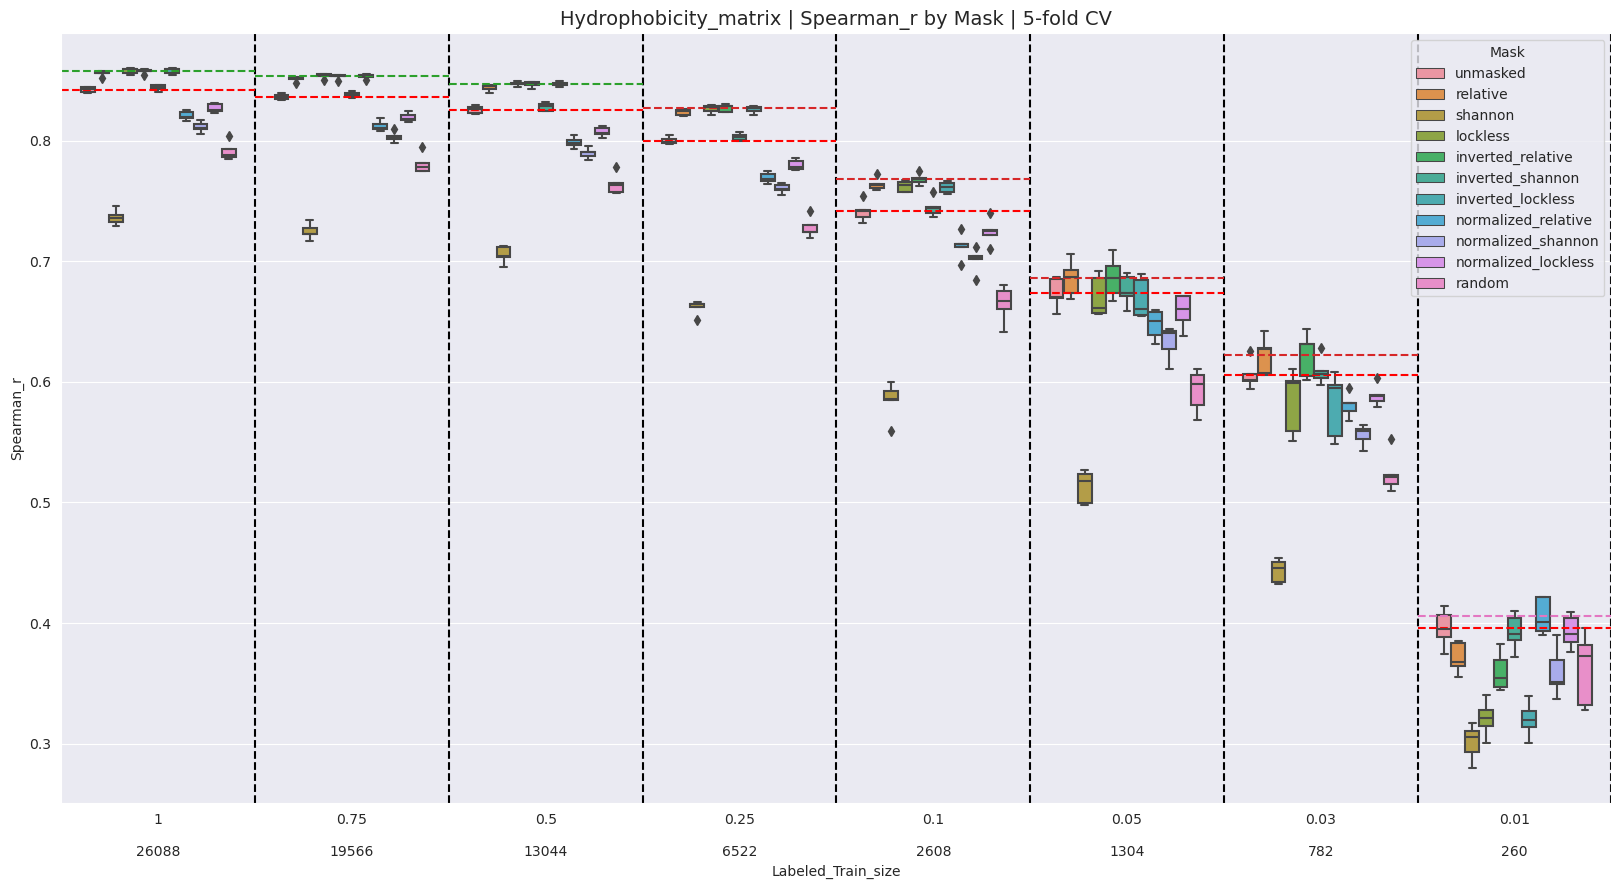

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


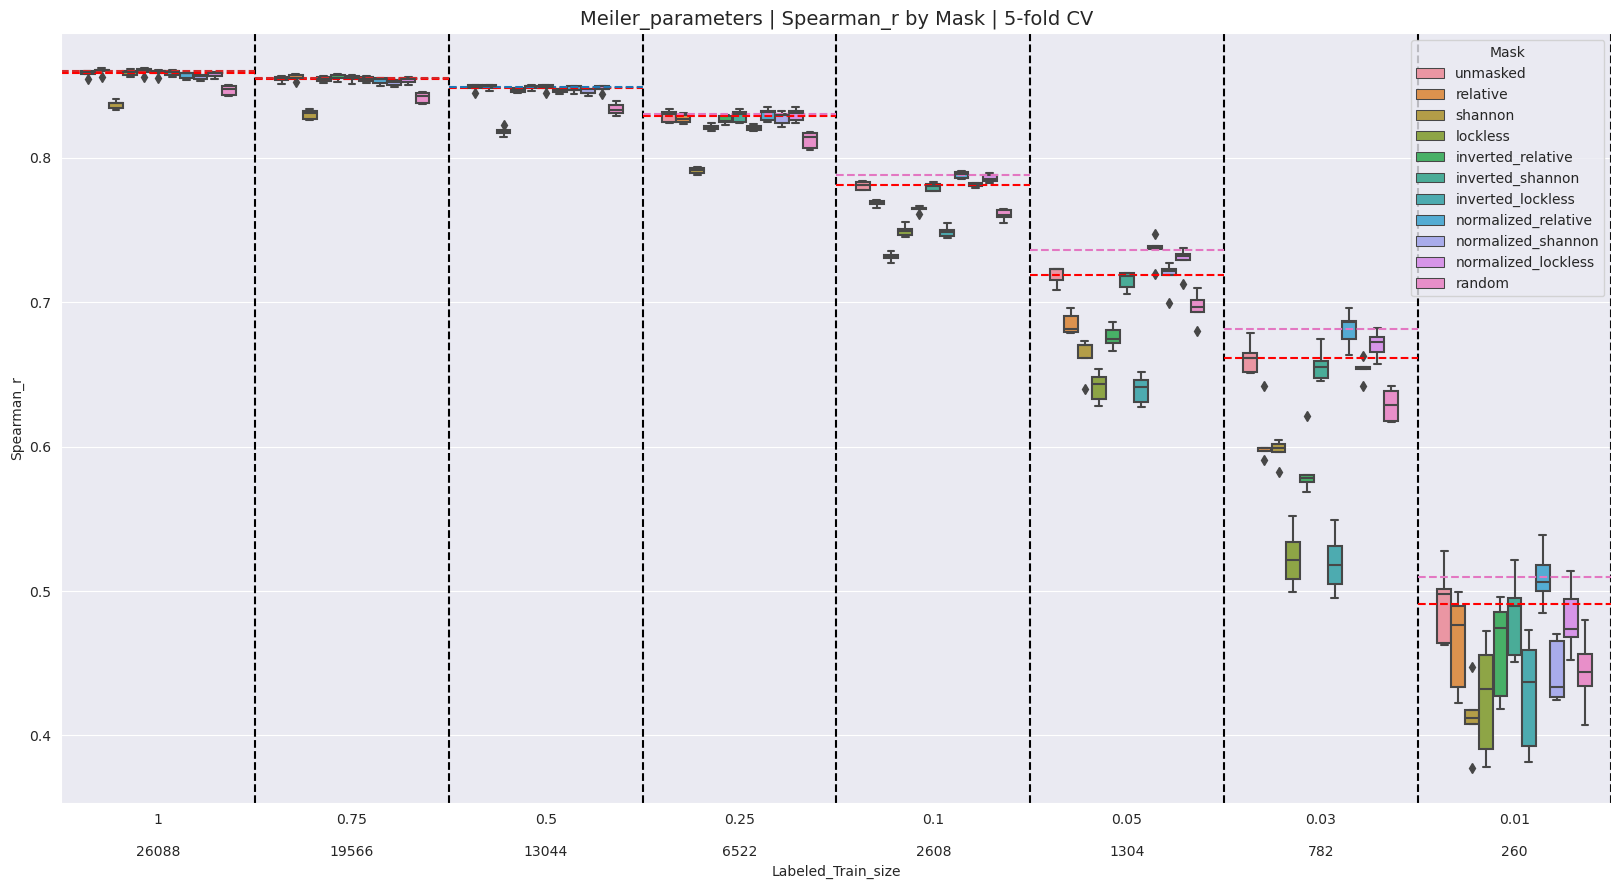

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


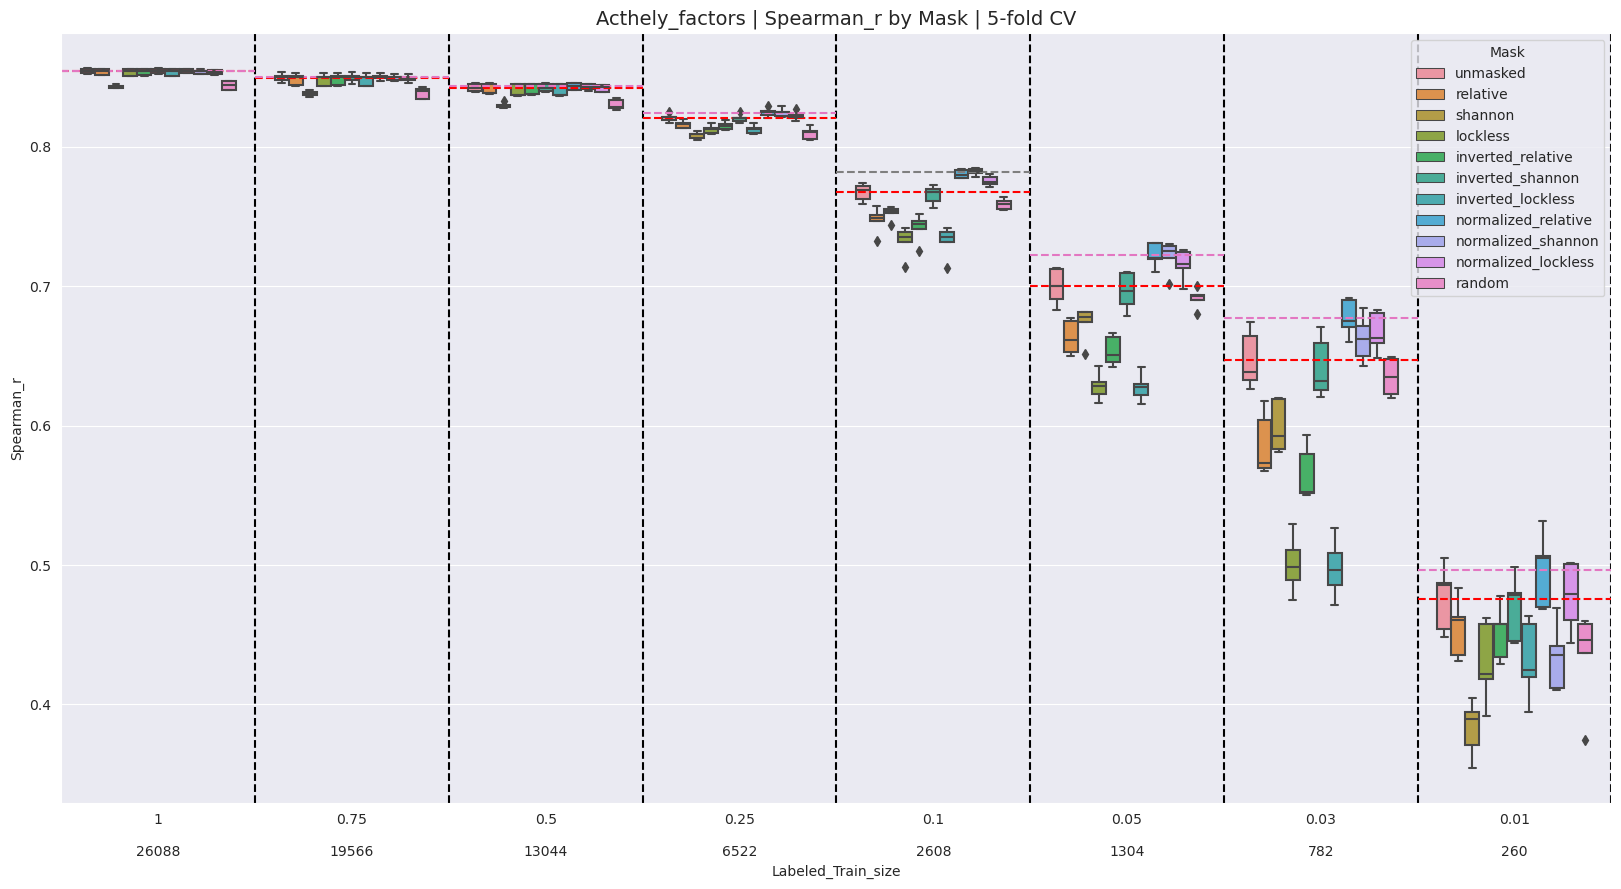

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


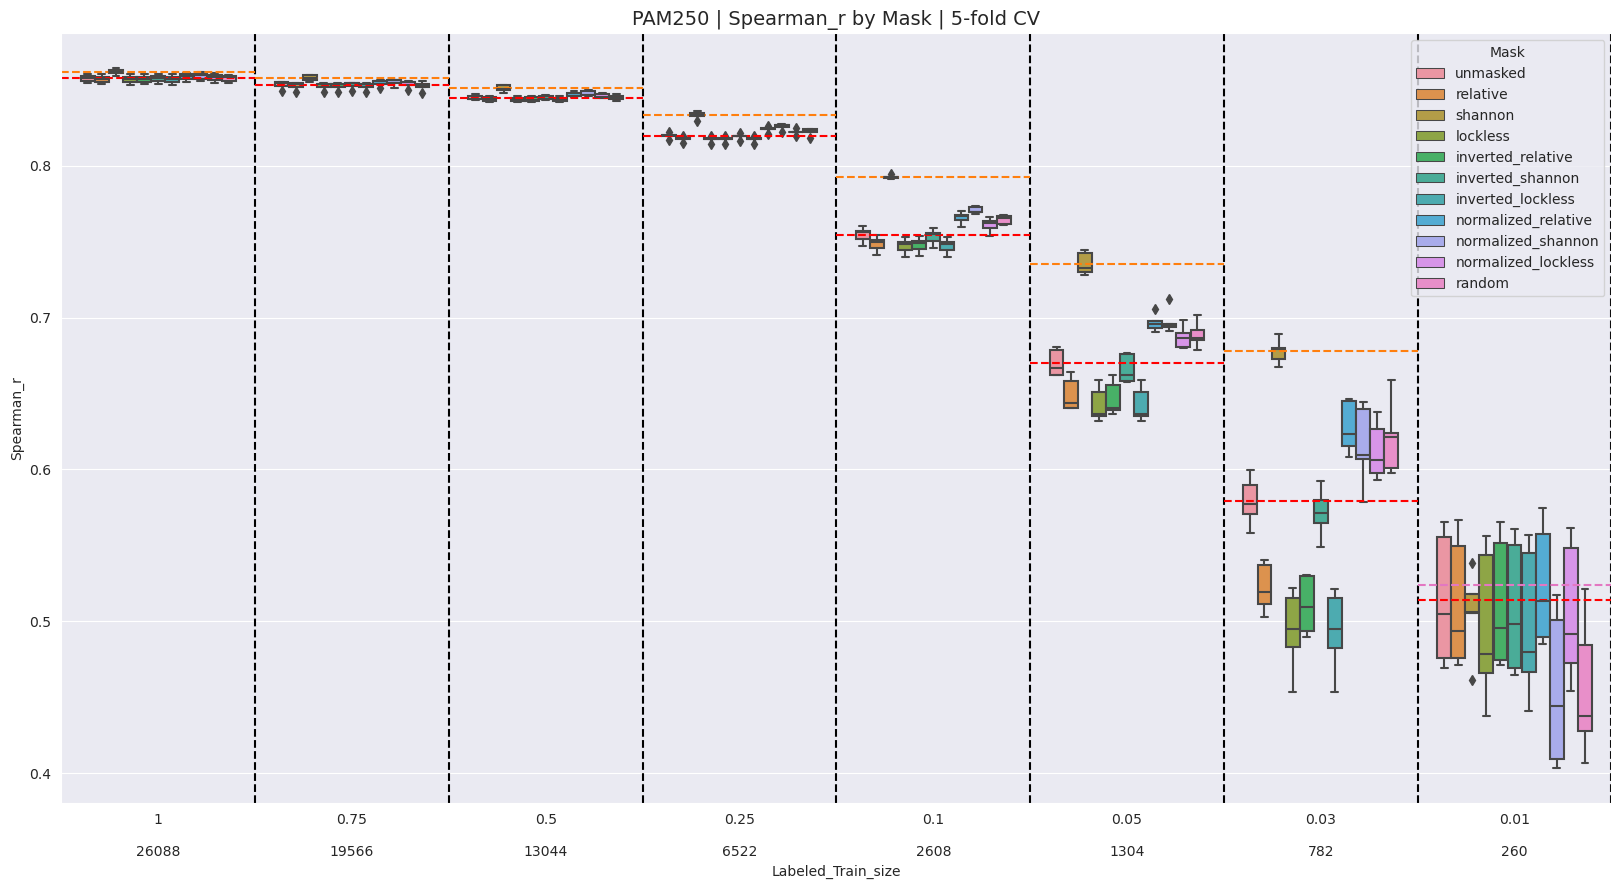

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


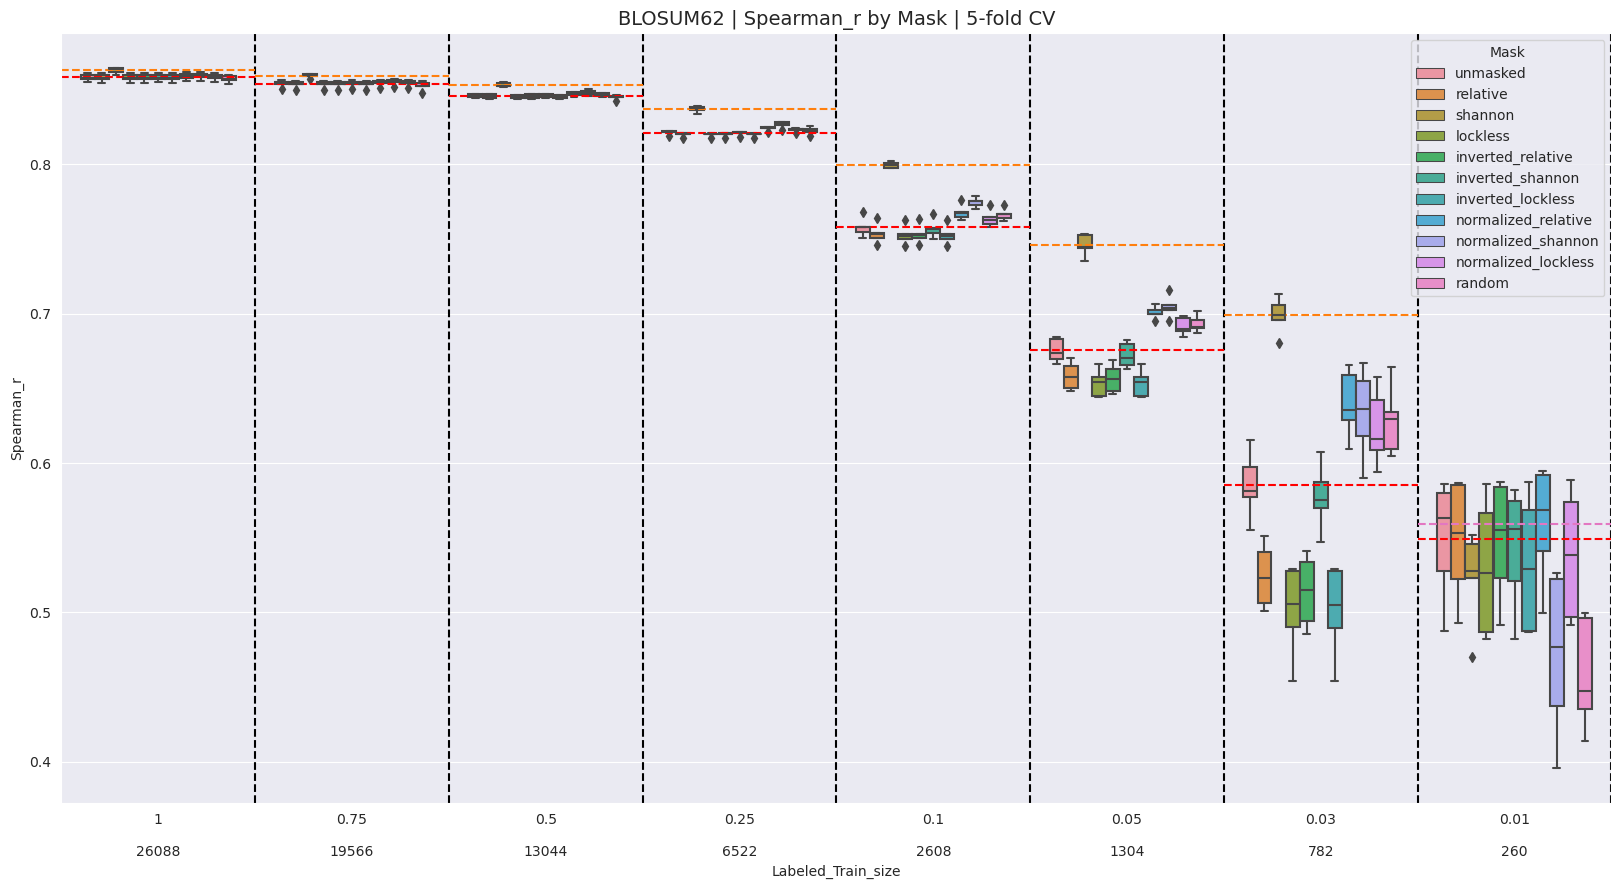

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


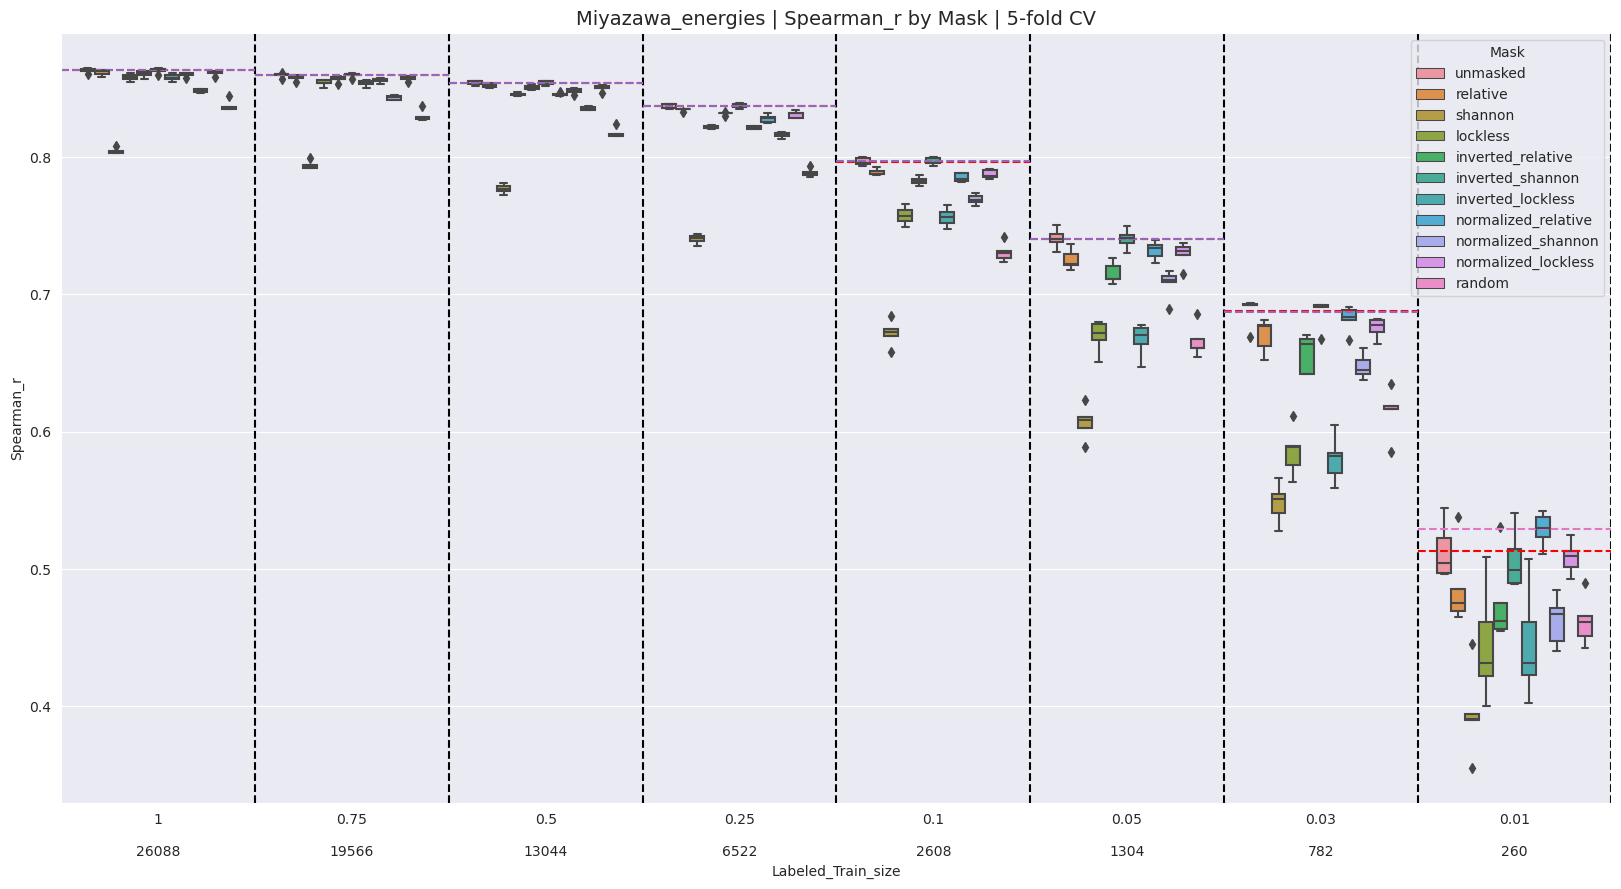

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


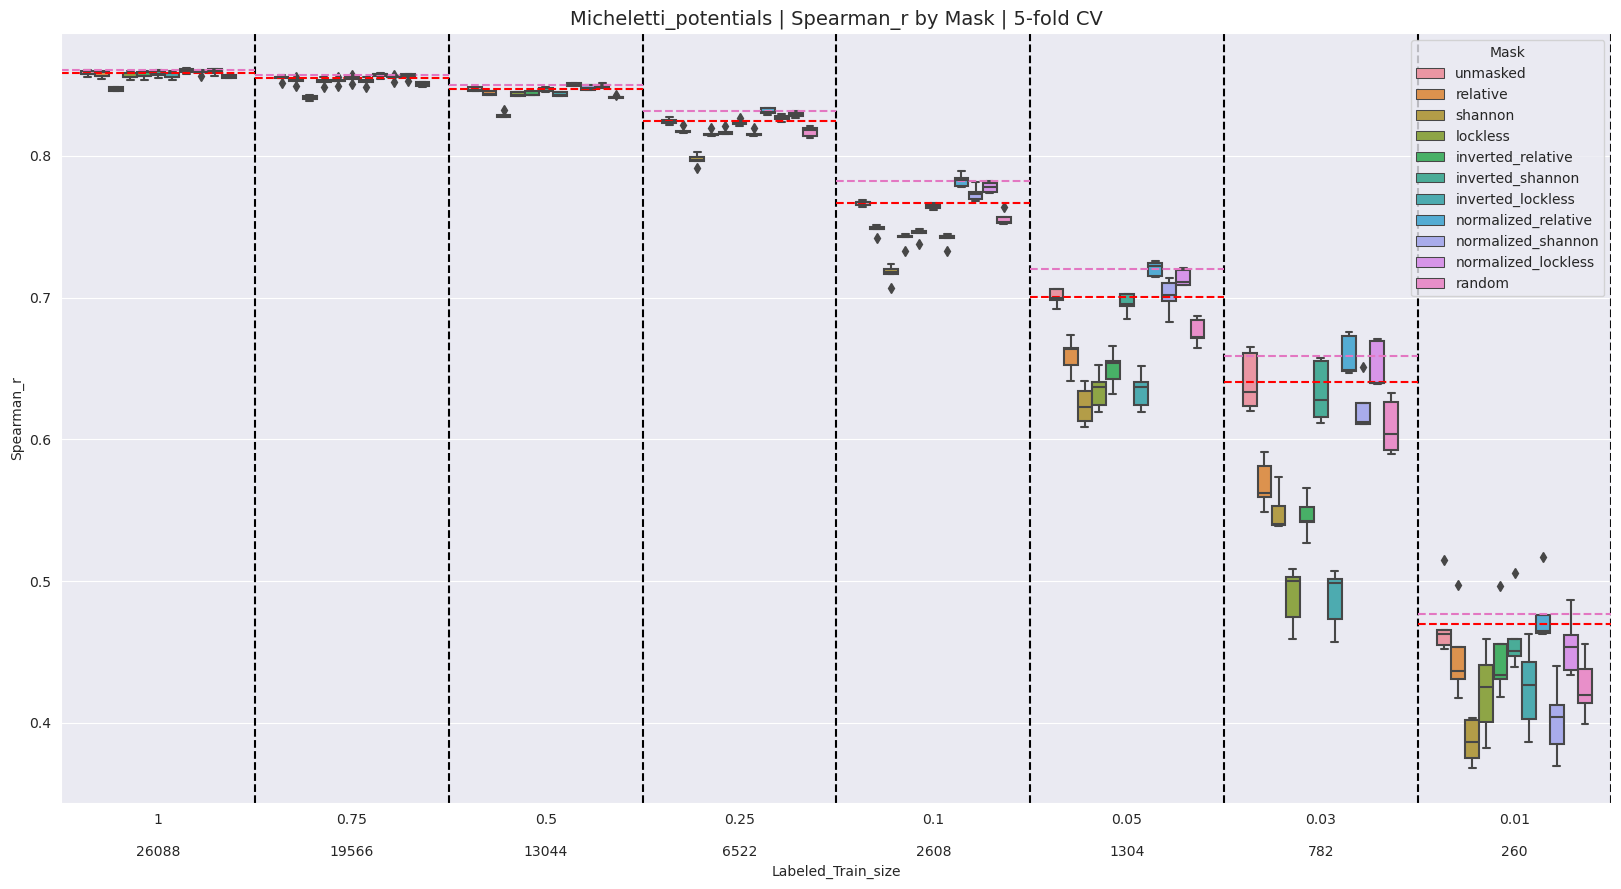

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


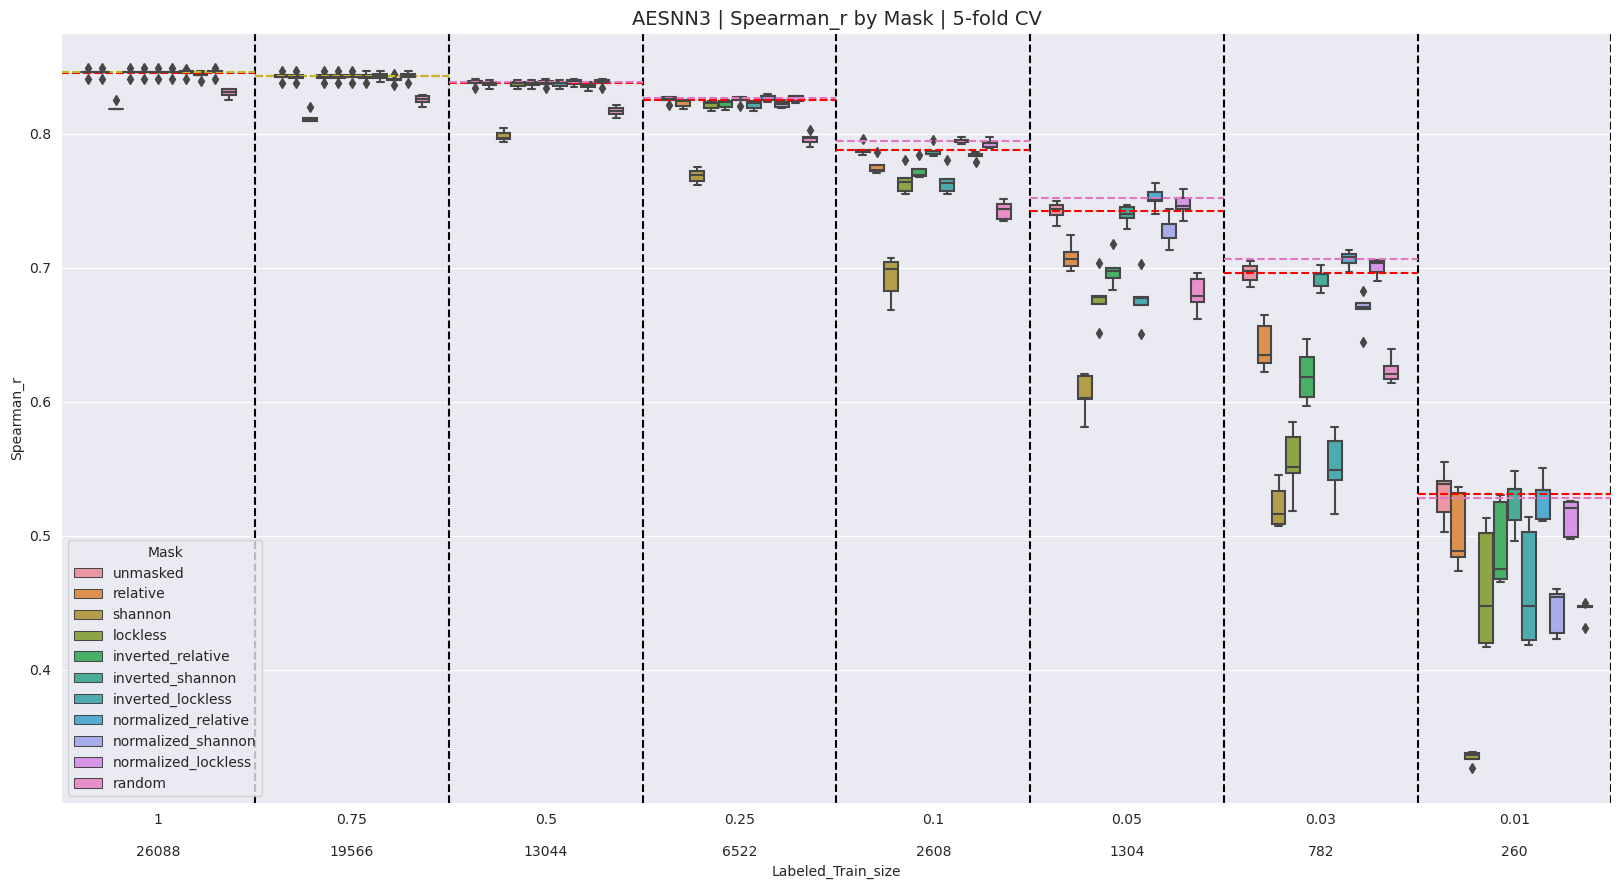

/tmp/ipykernel_3789463/2905393285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_3789463/2905393285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


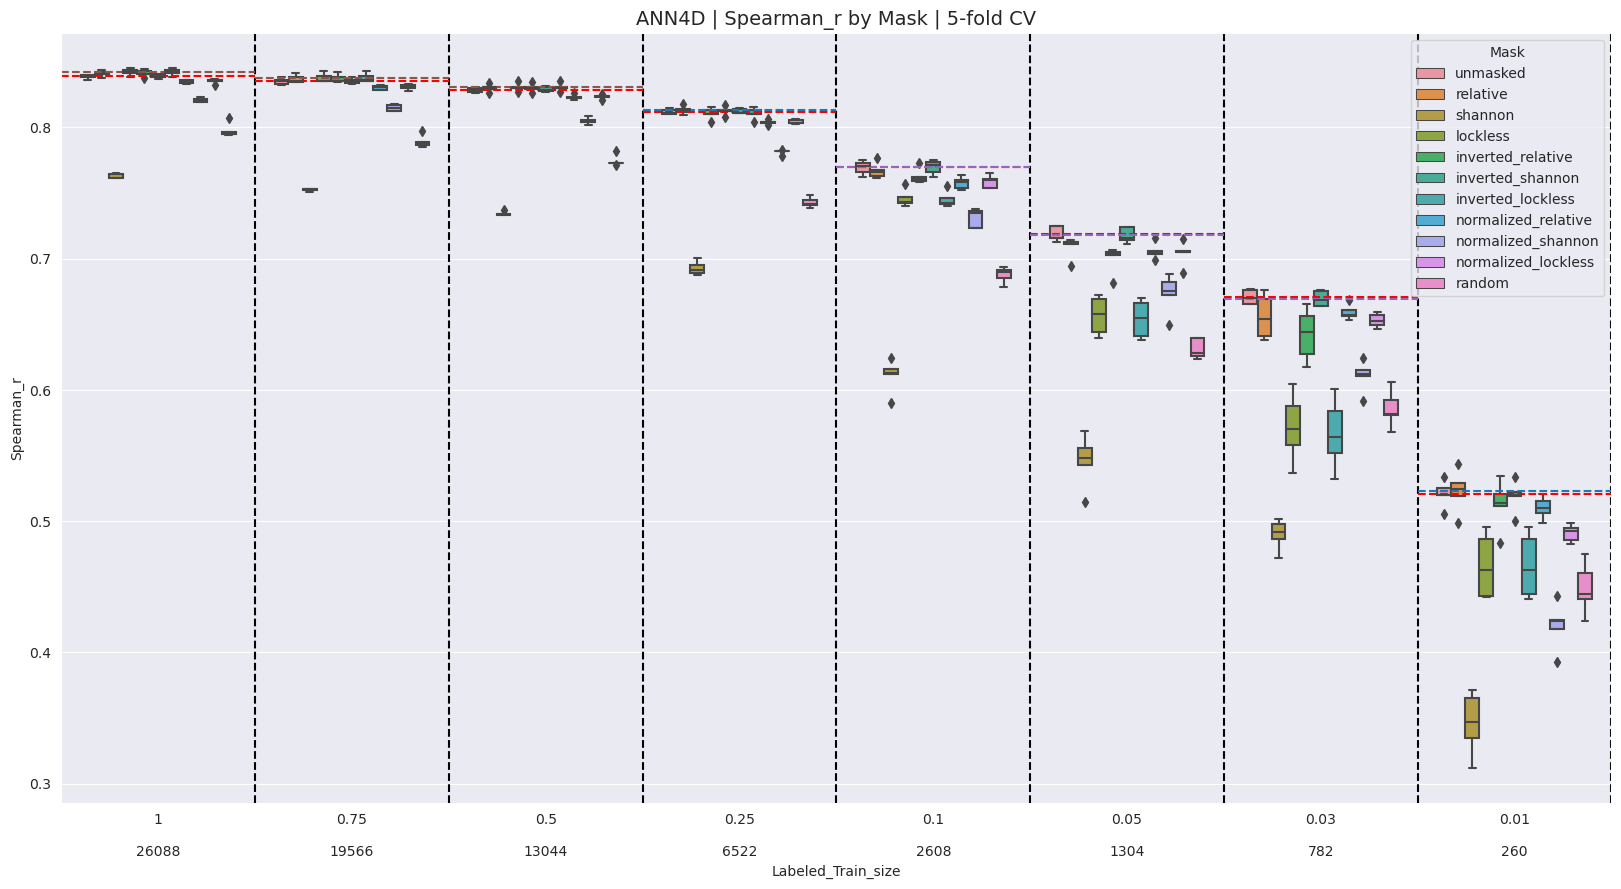

In [17]:
selected_metric = "Spearman_r"
for enc in encodings:
    
    plt.figure(figsize=(20, 10))

    boxplot_df = df.loc[(df["Encoding"] == enc)]
    boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
    boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)
    # Boxplot grouped by labeled
    # Vertical and horizontal grid background
    sns.set_style("darkgrid")
    sns.boxplot(x="Labeled_Train_size", y=selected_metric, hue="Mask", data=boxplot_df)
    [plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each labeled group
    for labeled in labeled_sizes_list:
        plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] == "unmasked")][selected_metric].mean(), 
                    xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list), 
                    color = 'red', linestyle='--')
        # Draw anothe line with the best value other than unmasked
        if selected_metric == 'MSE' or selected_metric == 'RMSE':
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin(),
            best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                        xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list),
                        color = best_mask_color, linestyle='--')
        else:
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
            best_mask_color = sns.color_palette()[masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                        xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list),
                        color = best_mask_color, linestyle='--')
                        

    plt.title(f'{enc} | {selected_metric} by Mask | 5-fold CV', fontsize=14)
    plt.show()